/Users/yunlinz/Documents/Python/main/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


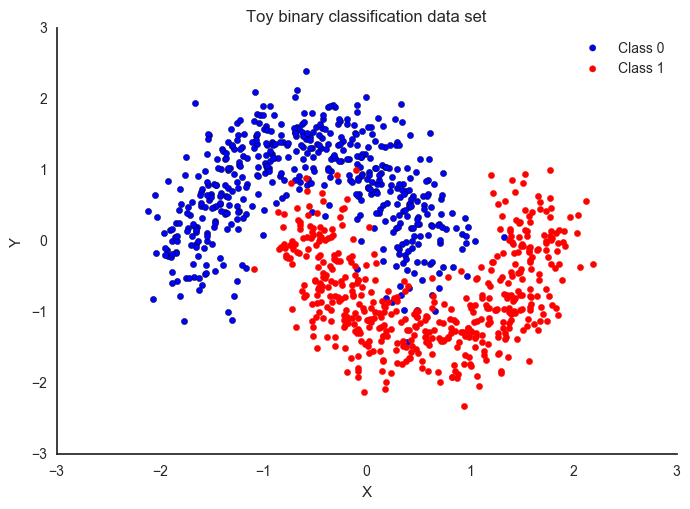

In [2]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [91]:
combined_data = np.concatenate((X, Y.reshape(-1,1)), axis = 1)
mask = np.random.binomial(1, 0.3, size=combined_data.shape).astype(bool)
masked_data = np.ma.masked_array(combined_data, mask=mask)

In [92]:
non_masked = combined_data[~mask[:,0] & ~mask[:,1] & ~mask[:,2]]
all_masked = combined_data[mask[:,0] & mask[:,1] & mask[:,2]]
x_masked = combined_data[mask[:,0] & ~mask[:,1]]
y_masked = combined_data[~mask[:,0] & mask[:,1]]
label_only = combined_data[mask[:,0] & mask[:,1] & ~mask[:,2]]
coord_only = combined_data[~mask[:,0] & ~mask[:,1] & mask[:,2]]

train_data = combined_data[~mask[:,0] | ~mask[:,1] | ~mask[:,2]]

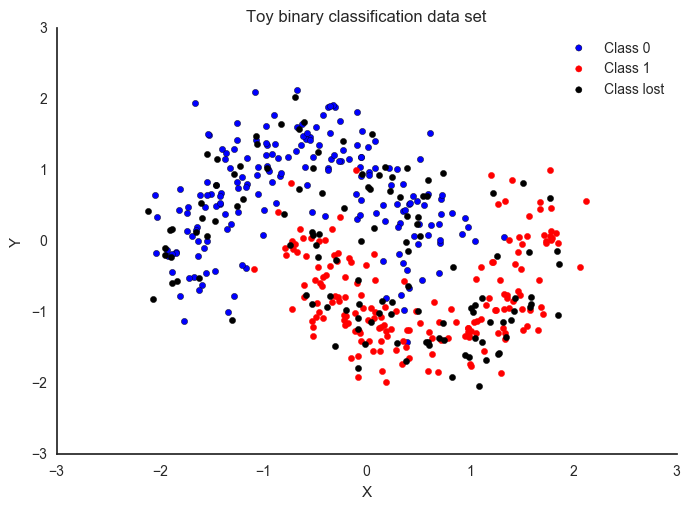

In [93]:
fig, ax = plt.subplots()
ax.scatter(non_masked[non_masked[:,2]==0, 0], non_masked[non_masked[:,2]==0, 1], label='Class 0')
ax.scatter(non_masked[non_masked[:,2]==1, 0], non_masked[non_masked[:,2]==1, 1], color='r', label='Class 1')
ax.scatter(coord_only[:,0], coord_only[:,1], color='black', label='Class lost')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [94]:
def sigmoid(x):
    lambda(x): 1.0/(1.0+exp(-x))

    

latent_size = 2

hidden_1 = 3
hidden_2 = 5
out = 4

v   = np.random.randn(train_data.shape[0], latent_size)
w_1 = np.random.randn(latent_size, hidden_1)
w_2 = np.random.randn(hidden_1, hidden_2)
w_3 = np.random.randn(hidden_2, out)

with pm.Model() as imputer:
    latent_v = pm.Normal('v', 0, sd=1, shape=(train_data.shape[0], latent_size), testval=v)
    weight_1 = pm.Normal('w_1', 0, sd=1, shape=(latent_size, hidden_1), testval=w_1)
    weight_2 = pm.Normal('w_2', 0, sd=1, shape=(hidden_1, hidden_2), testval=w_2)
    weight_3 = pm.Normal('w_3', 0, sd=1, shape=(hidden_2, out), testval=w_3)
    
    act_1 = T.nnet.sigmoid(T.dot(latent_v, weight_1))
    act_2 = T.nnet.sigmoid(T.dot(act_1, weight_2))
    output = T.dot(act_2, weight_3)
    
    labels = pm.Bernoulli('label', act_2[:,0], observed=train_data[:,2])
    x_coords = pm.Normal('x', output[:,0], sd=output[:,1], observed=train_data[:,0])
    y_coords = pm.Normal('y', output[:,2], sd=output[:,3], observed=train_data[:,1])

In [ ]:
from pymc3 import sample

with imputer:
    trace = sample(5000)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -3,527.4: 100%|██████████| 200000/200000 [04:05<00:00, 814.78it/s]
Finished [100%]: Average ELBO = -3,527
 12%|█▏        | 611/5000 [18:41<9:06:10,  7.47s/it] 

In [ ]:
from pymc3 import traceplot

traceplot(trace)

In [ ]:
ppc = pm.sample_ppc(trace, samples=1, model=imputer, size=1)

In [75]:
for k in ppc.items():
    print(k)

('y', array([[ 0.14727768, -0.1765559 ,  0.8946667 , -0.24481249, -1.58751491,
         1.15728312, -0.30436684,  1.47014145,  2.0399177 , -1.60479073,
         0.983455  ,  0.28959728,  0.62680295, -0.87670225,  0.03139881,
        -0.66486726,  0.59965353,  0.33344267,  1.03984508, -0.42972874,
         0.28159778,  1.57983989,  0.13387705, -1.23091205, -0.50350764,
         0.0514795 , -1.36802228, -0.18053247, -2.10999428,  1.23745194,
        -1.65162039, -0.54354493,  1.3348033 , -0.14011509,  0.98014293,
         1.55324551, -0.77348661, -1.02203975, -1.63016179,  1.18997972,
        -0.55907421,  0.05353314,  0.95266356,  2.14374462, -0.86132884,
         1.17529308,  0.67380837,  1.32958208, -0.14574429, -0.21618477,
        -0.22870328,  0.02716224,  1.38917534, -0.38172569,  1.58191931,
         0.75865388, -0.48237387,  0.88378999,  0.81406981,  0.90007137,
         1.47937533,  0.97015542,  1.15605666, -0.16018125, -1.33440083,
        -0.28701709,  1.99336668, -0.32057906

In [ ]:
fig, ax = plt.subplots()
ax.scatter(ppc['x'].T[ppc['label'].T==0], ppc['y'].T[ppc['label'].T==0], label='Class 0')
ax.scatter(ppc['x'].T[ppc['label'].T==1], ppc['y'].T[ppc['label'].T==1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [81]:
sample_x = ppc['x'].T
sample_y = ppc['y'].T
sample_label = ppc['label'].T

In [82]:
print(sample_x.shape)
print(sample_y.shape)
print(sample_label.shape)

(863, 1)
(863, 1)
(863, 1)


In [84]:
sample_x

array([[ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [